17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1 Layer, 32 Units: Test Accuracy = 0.8654
2 Layers, 32 Units: Test Accuracy = 0.8609
3 Layers, 32 Units: Test Accuracy = 0.8552
2 Layers, 64 Units: Test Accuracy = 0.8656
2 Layers, 128 Units: Test Accuracy = 0.8734
2 Layers, 32 Units, MSE Loss: Test Accuracy = 0.8642
2 Layers, 32 Units, tanh Activation: Test Accuracy = 0.8488
2 Layers, 32 Units, w/ Dropout: Test Accuracy = 0.8749
2 Layers, 32 Units, Dropout + L2: Test Accuracy = 0.8753


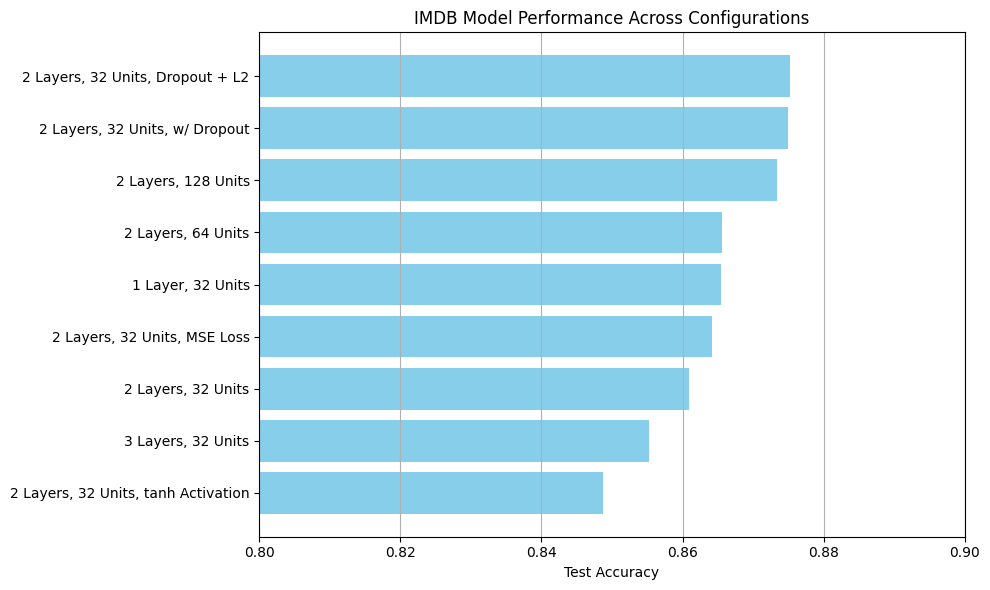


Final Results Table
                      Configuration  Validation Accuracy  Test Accuracy
   2 Layers, 32 Units, Dropout + L2               0.8910        0.87528
     2 Layers, 32 Units, w/ Dropout               0.8968        0.87492
                2 Layers, 128 Units               0.8884        0.87344
                 2 Layers, 64 Units               0.8888        0.86564
                  1 Layer, 32 Units               0.8940        0.86544
       2 Layers, 32 Units, MSE Loss               0.8902        0.86424
                 2 Layers, 32 Units               0.8842        0.86088
                 3 Layers, 32 Units               0.8896        0.85520
2 Layers, 32 Units, tanh Activation               0.8890        0.84876


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import regularizers

VOCAB_SIZE = 10000
BATCH_SIZE = 512
EPOCHS = 20
VALIDATION_SPLIT = 0.2

def load_data(vocab_size):
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

    def vectorize(sequences):
        result = np.zeros((len(sequences), vocab_size))
        for i, seq in enumerate(sequences):
            result[i, seq] = 1.0
        return result

    x_train = vectorize(train_data)
    x_test = vectorize(test_data)
    y_train = np.asarray(train_labels).astype("float32")
    y_test = np.asarray(test_labels).astype("float32")
    return x_train, y_train, x_test, y_test

#Build Model Function
def build_model(hidden_layers=2, hidden_units=32, activation='relu',
                loss_fn='binary_crossentropy', use_dropout=False, use_l2=False):

    model = Sequential()
    reg = regularizers.l2(0.001) if use_l2 else None

    model.add(Dense(hidden_units, activation=activation, input_shape=(VOCAB_SIZE,), kernel_regularizer=reg))
    if use_dropout:
        model.add(Dropout(0.5))

    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation=activation, kernel_regularizer=reg))
        if use_dropout:
            model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=RMSprop(learning_rate=0.001), loss=loss_fn, metrics=['accuracy'])
    return model

def train_and_evaluate(config_name, **kwargs):
    model = build_model(**kwargs)
    history = model.fit(x_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=VALIDATION_SPLIT,
                        verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{config_name}: Test Accuracy = {test_acc:.4f}")
    return {
        "Configuration": config_name,
        "Validation Accuracy": max(history.history['val_accuracy']),
        "Test Accuracy": test_acc
    }

x_train, y_train, x_test, y_test = load_data(VOCAB_SIZE)

results = []

#1 Vary number of hidden layers
results.append(train_and_evaluate("1 Layer, 32 Units", hidden_layers=1))
results.append(train_and_evaluate("2 Layers, 32 Units", hidden_layers=2))
results.append(train_and_evaluate("3 Layers, 32 Units", hidden_layers=3))

#2 Vary number of units
results.append(train_and_evaluate("2 Layers, 64 Units", hidden_layers=2, hidden_units=64))
results.append(train_and_evaluate("2 Layers, 128 Units", hidden_layers=2, hidden_units=128))

# 3. Use MSE loss
results.append(train_and_evaluate("2 Layers, 32 Units, MSE Loss", loss_fn='mean_squared_error'))

# 4. Use tanh activation
results.append(train_and_evaluate("2 Layers, 32 Units, tanh Activation", activation='tanh'))

# 5. Use Dropout
results.append(train_and_evaluate("2 Layers, 32 Units, w/ Dropout", use_dropout=True))

# 6. Use Dropout + L2 Regularization
results.append(train_and_evaluate("2 Layers, 32 Units, Dropout + L2", use_dropout=True, use_l2=True))

df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='Test Accuracy', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Configuration'], df_sorted['Test Accuracy'], color='skyblue')
plt.xlabel("Test Accuracy")
plt.title("IMDB Model Performance Across Configurations")
plt.xlim(0.8, 0.9)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

print("\nFinal Results Table")
print(df_results.sort_values(by='Test Accuracy', ascending=False).to_string(index=False))

